In [1]:
#### ---------------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: July 8, 2025
#### predict individual BRCA Subtype Status using All HoverNet predicted NPIFs and also save the models for external validation
#### ----------------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter, defaultdict
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import random
import joblib

_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)

print(f"working directory = {_wpath_}\n")



working directory = /data/Lab_ruppin/Ranjan/HnE/



In [2]:
# Define dataset and file paths
dataset_name = "TCGA_BRCA_FFPE"
outcome_names = ["HER2_Status", "PR_Status", "ER_Status"]

# File paths
hovernet_NPIFs_with_BRCA_status_file = f"{dataset_name}/outputs/HoverNet/Subtypes/HoverNet_Original_NPIFs_Values_TCGA_BRCA_Mapped_BRCA_Status.csv"

# Output path to save results and plots
out_path = f"{dataset_name}/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/"
model_save_path = os.path.join(out_path, "saved_models/")
os.makedirs(model_save_path, exist_ok=True) # Creates directory if it doesn't exist already

# read files 
hovernet_NPIFs_with_BRCA_status_full = pd.read_csv(hovernet_NPIFs_with_BRCA_status_file)

# Remove trailing spaces from column names
hovernet_NPIFs_with_BRCA_status_full.columns = hovernet_NPIFs_with_BRCA_status_full.columns.str.strip()


# Rename the column
hovernet_NPIFs_with_BRCA_status_full.rename(columns={"sampleID": "sample_id"}, inplace=True)

# The number of samples used for TCGA BRCA subtype prediction 
TCGA_BRCA_Subtypes_556_file = f"{dataset_name}/outputs/HoverNet/Subtypes/outputs_biomarker_status_prediction_results_All_HoverNet_NPIFs/combined_class_predictions_all_features_for_subtypes.csv"

TCGA_BRCA_Subtypes_556 = pd.read_csv(TCGA_BRCA_Subtypes_556_file)

# Convert the first column ("sample") to a series
sample_list_556 = TCGA_BRCA_Subtypes_556['sample_id'].reset_index(drop=True)

# Filter sample based on `sample_list_556`
hovernet_NPIFs_with_BRCA_status_full = hovernet_NPIFs_with_BRCA_status_full[hovernet_NPIFs_with_BRCA_status_full['sample_id'].isin(sample_list_556)].copy()

# Convert the first column ("sample") to a series
patient_list = hovernet_NPIFs_with_BRCA_status_full['sample_id'].reset_index(drop=True)

# Filter to include only rows where outcome is "Positive" or "Negative"
data_filtered = hovernet_NPIFs_with_BRCA_status_full[
    hovernet_NPIFs_with_BRCA_status_full[outcome_names].isin(["Positive", "Negative"]).all(axis=1)
]

# Filter out the patient list
filtered_patient_list = data_filtered['sample_id'].reset_index(drop=True)

# Define features (before normalization)
X = data_filtered.iloc[:, 4:].copy()


hovernet_NPIFs_with_BRCA_status_full
filtered_patient_list
data_filtered
# X

,sample_id,HER2_Status,PR_Status,ER_Status,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,TCGA-A1-A0SB,Negative,Negative,Positive,9.195387,4.321033,2.915560,12.345927,0.691851,0.740468,4.043874,1.111174,0.666327,3.044964,0.146049,0.103458
1,TCGA-A1-A0SD,Negative,Positive,Positive,10.990767,4.598732,3.237783,13.198198,0.660687,0.764008,5.337735,1.237818,0.782514,3.338023,0.153062,0.097086
2,TCGA-A1-A0SE,Negative,Positive,Positive,11.248593,4.661373,3.277948,13.351101,0.666076,0.766299,5.136734,1.180780,0.762165,3.218593,0.147333,0.092280
3,TCGA-A1-A0SF,Negative,Positive,Positive,13.471537,5.184088,3.504886,14.653101,0.691533,0.749764,7.607367,1.549759,0.976177,4.244868,0.145507,0.096608
4,TCGA-A1-A0SH,Negative,Positive,Negative,12.127593,4.886405,3.354515,13.920132,0.676842,0.753368,6.608414,1.466462,0.876198,3.939578,0.149730,0.102938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,TCGA-EW-A1PB,Negative,Negative,Negative,12.412278,4.800650,3.416715,13.862514,0.654321,0.764706,6.683823,1.328402,0.977391,3.737845,0.159393,0.095545
711,TCGA-EW-A1PD,Positive,Positive,Positive,12.608980,5.084656,3.349750,14.658306,0.702925,0.699644,7.695761,1.644407,1.011241,4.622193,0.149923,0.117395
712,TCGA-EW-A1PE,Negative,Positive,Positive,13.904235,5.093487,3.613989,14.562767,0.658886,0.773454,6.785858,1.343361,0.977925,3.650983,0.154884,0.097561
713,TCGA-EW-A1PF,Negative,Positive,Positive,12.666117,4.996555,3.389470,14.254749,0.683962,0.739705,6.951075,1.480680,0.971618,3.997046,0.155604,0.107671


In [3]:
# Initialize a DataFrame to store the combined results
combined_results_df = pd.DataFrame({'sample_id': filtered_patient_list.values})
combined_results_df.set_index('sample_id', inplace=True)

# Define hyperparameter grid for Logistic Regression with L2 penalty (Ridge)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Define cross-validation parameters
n_folds = 5
seed = 20852
shuffle = True

# Define subtype names
subtype_names_3 = ['HER2_Positive', 'HR_Positive', 'TNBC_3']
subtype_names_4 = ['HR+', 'TNBC_4', 'TPBC', 'HER2+']
all_subtype_names = subtype_names_3 + subtype_names_4

# Step 1: Define true subtypes from HER2/ER/PR status
def define_true_subtypes(df):
    HER2 = df['HER2_Status'] == 'Positive'
    ER = df['ER_Status'] == 'Positive'
    PR = df['PR_Status'] == 'Positive'

    df['HER2_Positive'] = HER2.astype(int)
    df['HR_Positive'] = ((ER | PR) & ~HER2).astype(int)
    df['TNBC_3'] = (~HER2 & ~ER & ~PR).astype(int)

    df['HR+'] = (ER & ~HER2).astype(int)
    df['TNBC_4'] = (~ER & ~HER2).astype(int)
    df['TPBC'] = (ER & HER2).astype(int)
    df['HER2+'] = (~ER & HER2).astype(int)

    return df

# Apply subtype definition
data_filtered = define_true_subtypes(data_filtered)

# Step 2: Define NPIF features only (exclude all label-related columns)
columns_to_exclude = ['sample_id', 'HER2_Status', 'PR_Status', 'ER_Status',
                      'HER2_Positive', 'HR_Positive', 'TNBC_3', 'HR+',
                      'TNBC_4', 'TPBC', 'HER2+']
feature_columns = [col for col in data_filtered.columns if col not in columns_to_exclude]
X = data_filtered[feature_columns].copy()

data_filtered
# feature_columns
# X

,sample_id,HER2_Status,PR_Status,ER_Status,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,...,Std Perimeter,Std Eccentricity,Std Circularity,HER2_Positive,HR_Positive,TNBC_3,HR+,TNBC_4,TPBC,HER2+
0,TCGA-A1-A0SB,Negative,Negative,Positive,9.195387,4.321033,2.915560,12.345927,0.691851,0.740468,...,3.044964,0.146049,0.103458,0,1,0,1,0,0,0
1,TCGA-A1-A0SD,Negative,Positive,Positive,10.990767,4.598732,3.237783,13.198198,0.660687,0.764008,...,3.338023,0.153062,0.097086,0,1,0,1,0,0,0
2,TCGA-A1-A0SE,Negative,Positive,Positive,11.248593,4.661373,3.277948,13.351101,0.666076,0.766299,...,3.218593,0.147333,0.092280,0,1,0,1,0,0,0
3,TCGA-A1-A0SF,Negative,Positive,Positive,13.471537,5.184088,3.504886,14.653101,0.691533,0.749764,...,4.244868,0.145507,0.096608,0,1,0,1,0,0,0
4,TCGA-A1-A0SH,Negative,Positive,Negative,12.127593,4.886405,3.354515,13.920132,0.676842,0.753368,...,3.939578,0.149730,0.102938,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,TCGA-EW-A1PB,Negative,Negative,Negative,12.412278,4.800650,3.416715,13.862514,0.654321,0.764706,...,3.737845,0.159393,0.095545,0,0,1,0,1,0,0
711,TCGA-EW-A1PD,Positive,Positive,Positive,12.608980,5.084656,3.349750,14.658306,0.702925,0.699644,...,4.622193,0.149923,0.117395,1,0,0,0,0,1,0
712,TCGA-EW-A1PE,Negative,Positive,Positive,13.904235,5.093487,3.613989,14.562767,0.658886,0.773454,...,3.650983,0.154884,0.097561,0,1,0,1,0,0,0
713,TCGA-EW-A1PF,Negative,Positive,Positive,12.666117,4.996555,3.389470,14.254749,0.683962,0.739705,...,3.997046,0.155604,0.107671,0,1,0,1,0,0,0


In [4]:
# Initialize result storage
results = {}
mean_f1_scores = []

# Loop through each subtype
for subtype in all_subtype_names:
    print(f"\nProcessing subtype: {subtype}")
    
    y = data_filtered[subtype]
    y_encoded = y.copy()

    outer_results = []
    y_true_all_folds = []
    predictions = []
    f1_scores = []

    # Track coefficients for all features across folds
    all_features = X.columns.tolist()
    coeff_tracker = {feat: [] for feat in all_features}  # values per fold, zero if not selected

    outer_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
    fold_idx = 1

    for train_idx, test_idx in outer_cv.split(X, y_encoded):
        print(f"\nOuter Fold {fold_idx}/{n_folds}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]
        patient_test_ids = filtered_patient_list.iloc[test_idx]

        # Print class balance
        print("Train class dist:", y_train.value_counts().to_dict())
        print("Test class dist :", y_test.value_counts().to_dict())

        inner_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
        
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', LogisticRegression(penalty='l1', solver='saga',
                                              class_weight='balanced', max_iter=10000))
        ])
        
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters: {best_params}")
        
        # Save model
        model_filename = os.path.join(model_save_path, f"{subtype}_model_fold_{fold_idx}.joblib")
        joblib.dump(best_model, model_filename)
        print(f"Saved model with scaler: {model_filename}")

        # Extract coefficients
        coef = best_model.named_steps['classifier'].coef_.flatten()
        for feat, c in zip(all_features, coef):
            coeff_tracker[feat].append(c)  # may be zero

        # Predict
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        predictions.append(y_pred_proba)
        y_true_all_folds.extend(y_test)

        # Save predictions to results DataFrame
        combined_results_df.loc[patient_test_ids.values, f'true_label_{subtype}'] = y_test.values
        combined_results_df.loc[patient_test_ids.values, f'predicted_probability_{subtype}'] = y_pred_proba

        # Evaluate
        f1 = f1_score(y_test, (y_pred_proba >= 0.5).astype(int))
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1_scores.append(f1)

        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC : {roc_auc:.4f}")

        outer_results.append({
            'fold': fold_idx,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'best_params': best_params
        })

        fold_idx += 1

    # Save results
    mean_f1_score = np.mean(f1_scores)
    print(f"Mean F1-score for {subtype}: {mean_f1_score:.4f}")

    results[subtype] = {
        'outer_results': outer_results,
        'mean_f1_score': mean_f1_score,
        'best_params': best_params
    }
    mean_f1_scores.append(mean_f1_score)

    # Fill missing folds with 0s
    for feat in coeff_tracker:
        if len(coeff_tracker[feat]) < n_folds:
            coeff_tracker[feat] += [0.0] * (n_folds - len(coeff_tracker[feat]))
    
    # Convert to DataFrame with fold-wise rows and features as columns
    fold_coefficients_df = pd.DataFrame(coeff_tracker)
    fold_coefficients_df.index.name = 'fold'
    fold_coefficients_df.index = [f'Fold_{i+1}' for i in range(n_folds)]
    
    # Save all coefficients (including zeros) fold-wise
    coeff_output_file = os.path.join(out_path, f"{subtype}_foldwise_coefficients.csv")
    fold_coefficients_df.to_csv(coeff_output_file)
    print(f"Saved fold-wise coefficients (including zeros) for {subtype} to: {coeff_output_file}")




Processing subtype: HER2_Positive

Outer Fold 1/5
Train class dist: {0: 378, 1: 66}
Test class dist : {0: 95, 1: 17}
Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2_Positive_model_fold_1.joblib
F1-score: 0.3793
ROC AUC : 0.7536

Outer Fold 2/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 10}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2_Positive_model_fold_2.joblib
F1-score: 0.3860
ROC AUC : 0.7671

Outer Fold 3/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2_Positive_

/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2+_model_fold_1.joblib
F1-score: 0.1000
ROC AUC : 0.6710

Outer Fold 2/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2+_model_fold_2.joblib
F1-score: 0.3333
ROC AUC : 0.9340

Outer Fold 3/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2+_model_fold_3.joblib
F1-score: 0.2424
ROC AUC : 0.8396

Outer Fold 4/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2+_model_fold_4.joblib
F1-score: 0.2941
ROC AUC : 0.9491

Outer Fold 5/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100}
Saved model with scaler: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/saved_models/HER2+_model_fold_5.joblib
F1-score: 0.1714
ROC AUC : 0.6906
Mean F1-score for HER2+: 0.2283
Saved fold-wise coefficients (including zeros) for HER2+ to: TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Lasso_Prediction_results_All_HoverNet_NPIFs_All_Tiles_Binary_Subtypes/HER2+_foldwise_coefficients.csv


In [5]:
# Save combined prediction outputs
combined_results_df.to_csv(os.path.join(out_path, 'combined_class_predictions_all_subtypes_binary.csv'), index=True)
combined_results_df

,true_label_HER2_Positive,predicted_probability_HER2_Positive,true_label_HR_Positive,predicted_probability_HR_Positive,true_label_TNBC_3,predicted_probability_TNBC_3,true_label_HR+,predicted_probability_HR+,true_label_TNBC_4,predicted_probability_TNBC_4,true_label_TPBC,predicted_probability_TPBC,true_label_HER2+,predicted_probability_HER2+
sample_id,,,,,,,,,,,,,,
TCGA-A1-A0SB,0.0,0.225931,1.0,0.844662,0.0,0.222839,1.0,0.884797,0.0,0.305713,0.0,0.293259,0.0,0.009109
TCGA-A1-A0SD,0.0,0.163560,1.0,0.815006,0.0,0.211686,1.0,0.810957,0.0,0.324211,0.0,0.143520,0.0,0.011598
TCGA-A1-A0SE,0.0,0.081428,1.0,0.903732,0.0,0.276832,1.0,0.903998,0.0,0.200882,0.0,0.179076,0.0,0.004105
TCGA-A1-A0SF,0.0,0.142452,1.0,0.553285,0.0,0.660442,1.0,0.572860,0.0,0.677635,0.0,0.321702,0.0,0.060173
TCGA-A1-A0SH,0.0,0.133830,1.0,0.809120,0.0,0.312305,0.0,0.727539,1.0,0.344097,0.0,0.198178,0.0,0.094162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EW-A1PB,0.0,0.416173,0.0,0.404539,1.0,0.495181,0.0,0.467666,1.0,0.456640,0.0,0.522958,0.0,0.423000
TCGA-EW-A1PD,1.0,0.105499,0.0,0.670942,0.0,0.776784,0.0,0.613694,0.0,0.590787,1.0,0.262761,0.0,0.010003
TCGA-EW-A1PE,0.0,0.512756,1.0,0.566347,0.0,0.379904,1.0,0.630298,0.0,0.206352,0.0,0.421060,0.0,0.064515


In [6]:
# Mapping for 3-subtype ROC plotting
subtypes_3 = {
    'HER2_Positive': ('true_label_HER2_Positive', 'predicted_probability_HER2_Positive'),
    'HR_Positive': ('true_label_HR_Positive', 'predicted_probability_HR_Positive'),
    'TNBC_3': ('true_label_TNBC_3', 'predicted_probability_TNBC_3')
}

# Mapping for 4-subtype ROC plotting
subtypes_4 = {
    'HR+': ('true_label_HR+', 'predicted_probability_HR+'),
    'TNBC_4': ('true_label_TNBC_4', 'predicted_probability_TNBC_4'),
    'TPBC': ('true_label_TPBC', 'predicted_probability_TPBC'),
    'HER2+': ('true_label_HER2+', 'predicted_probability_HER2+')
}


In [7]:
colors = {
    'HER2_Positive': 'darkorange',
    'HR_Positive': 'blue',
    'TNBC_3': 'green',
    'HR+': 'blue',
    'TNBC_4': 'green',
    'TPBC': 'tomato',
    'HER2+': 'darkorange'
}
def plot_combined_roc_curves(df, subtypes, title, filename):
    plt.figure(figsize=(10, 8))
    total_samples = len(df)

    for subtype, (true_label_col, pred_prob_col) in subtypes.items():
        if subtype in ['TNBC_3', 'TNBC_4']:
            if 'TNBC' in colors:  # Avoid duplicated legend for TNBC
                continue
            label = 'TNBC'
        elif subtype == 'HER2_Positive':
            label = 'HER2+'
        elif subtype == 'HR_Positive':
            label = 'HR+'
        else:
            label = subtype

        # Filter valid entries
        valid_indices = (~df[true_label_col].isna()) & (~df[pred_prob_col].isna())
        true_labels = df[true_label_col][valid_indices]
        predicted_probs = df[pred_prob_col][valid_indices]

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=colors[subtype], lw=2,
                 label=f'{label} (AUC = {roc_auc:.2f}, n = {true_labels.sum():.0f})')

    # Reference diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)

    # Save and show
    plt.savefig(os.path.join(out_path, filename), bbox_inches='tight')
    plt.show()


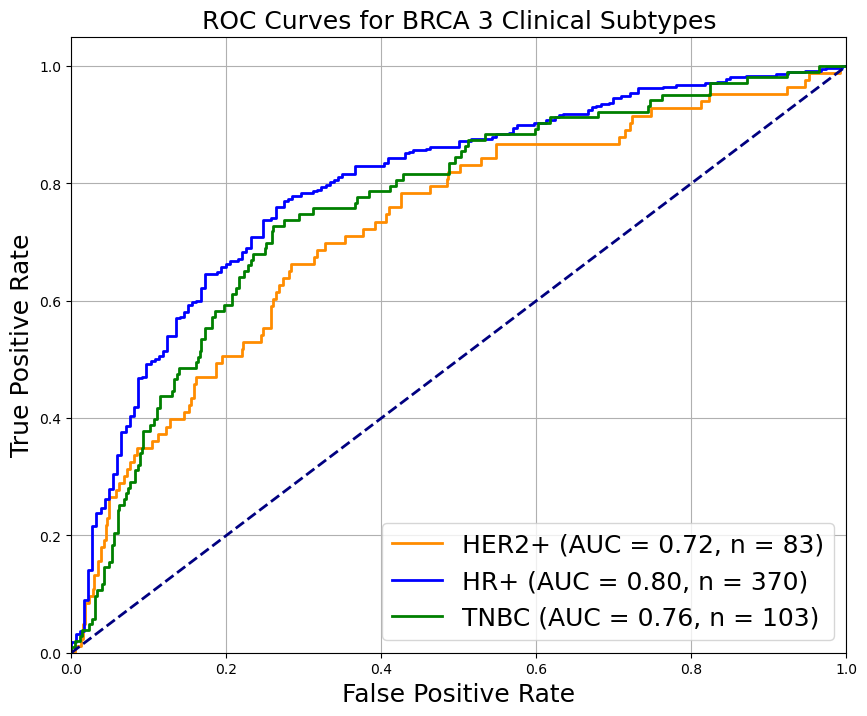

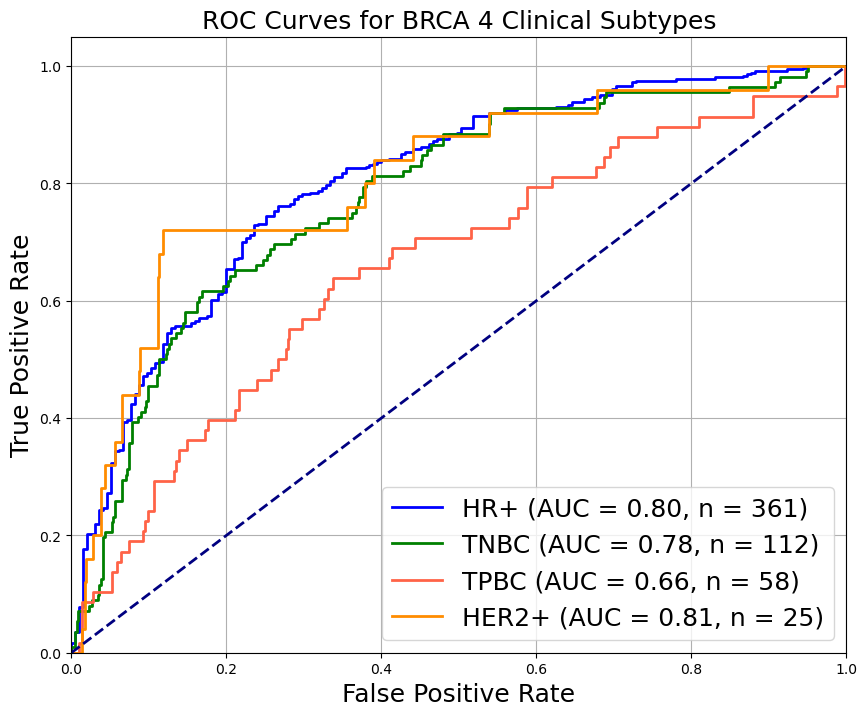

In [8]:
plot_combined_roc_curves(
    combined_results_df,
    subtypes_3,
    'ROC Curves for BRCA 3 Clinical Subtypes',
    'roc_3_subtypes.png'
)

plot_combined_roc_curves(
    combined_results_df,
    subtypes_4,
    'ROC Curves for BRCA 4 Clinical Subtypes',
    'roc_4_subtypes.png'
)

